In [1]:
import pandas as pd
import numpy as np 
import pickle
import tensorflow as tf
import torch
from itertools import product
from utils.embedding import CustomEmbeddingModel
from pykeen.models.predict import get_head_prediction_df, get_tail_prediction_df

In [2]:
# import models

transE = pickle.load(open('data/models/transE_model.p', 'rb'))
transE['model'].device = torch.device('cpu')
transR = pickle.load(open('data/models/transR_model.p', 'rb'))
transR['model'].device = torch.device('cpu')
convE = pickle.load(open('data/models/convE_model.p', 'rb'))
convE['model'].device = torch.device('cpu')
complEx = pickle.load(open('data/models/complEx_model.p', 'rb'))
complEx['model'].device = torch.device('cpu')
hierarchical_transR = pickle.load(open('data/models/custom_model.p', 'rb'))

In [3]:
# initialise hierarchical TransR model

model = CustomEmbeddingModel('data/KnowledgeGraph/SenescenceKG.json')

In [4]:
# do train/test/validation split
model.split(model.embedding_data, test_size = 0.1, 
            validation_size = 0.1, state = 123)

In [5]:
# initialize hierarchical transR model with trained parameters

hierarchical_transR_model_params = {name: value for name, value in hierarchical_transR['params'].items()
                                    if name != 'lr'}
optimizer = tf.keras.optimizers.Adam(learning_rate = hierarchical_transR['params']['lr'])
model.initializeModel(model.embedding_facts, **hierarchical_transR_model_params, optimizer = optimizer)
model.ent_embeddings = hierarchical_transR['ent_embeddings']
model.rel_embeddings = hierarchical_transR['rel_embeddings']
model.rel_matrices = hierarchical_transR['rel_matrices']

In [6]:
# get link predictions from the hierarchical transR model

def get_predictions_hTr(hTr_model, general_relation_lab, 
                        specific_relation_lab, entity_lab, 
                        which = 'head', entity_type = 'Gene',
                        drop_query = True):

    if which == 'head':
        predictions = hTr_model.getHeadPredictions(general_relation = hTr_model.embedding_gen_rel_lab2idx[general_relation_lab],
                                                   specific_relation = hTr_model.embedding_spec_rel_lab2idx[specific_relation_lab],
                                                   tail = hTr_model.embedding_node_lab2idx[entity_lab])
        predictions['head_label'] = [hTr_model.embedding_node_idx2lab[head] for head in predictions['head']]
        predictions = predictions[['head_label', 'score']]  
    else:
        predictions = hTr_model.getTailPredictions(general_relation = hTr_model.embedding_gen_rel_lab2idx[general_relation_lab],
                                                   specific_relation = hTr_model.embedding_spec_rel_lab2idx[specific_relation_lab],
                                                   head = hTr_model.embedding_node_lab2idx[entity_lab])
        predictions['tail_label'] = [hTr_model.embedding_node_idx2lab[tail] for tail in predictions['tail']]
        predictions = predictions[['tail_label', 'score']]
        
    if entity_type == 'Gene':
        predictions = predictions[predictions.iloc[:,0].str.contains('^ENS', regex = True)]
    else:
        predictions = predictions[predictions.iloc[:,0].str.contains('^GO', regex = True)]
        
    if drop_query:
        predictions = predictions[predictions.iloc[:,0] != entity_lab]
        
    predictions.rename({'score': 'Hierarchical TransR'}, axis = 1, inplace = True)
    return predictions

In [7]:
# function for getting PyKeen model predictions

def get_predictions_pykeen(model, model_name, relation_label, entity_label, triples_factory, which = 'head',
                           entity_type = 'Gene', drop_query = True):
    
    if which == 'head':
        predictions = get_head_prediction_df(model.cpu(), relation_label = relation_label, tail_label = entity_label, 
                                             triples_factory = triples_factory, add_novelties = False,
                                             remove_known = True)
        predictions.drop('head_id', axis = 1, inplace = True)
    else:
        predictions = get_tail_prediction_df(model.cpu(), relation_label = relation_label, head_label = entity_label, 
                                             triples_factory = triples_factory, add_novelties = False,
                                             remove_known = True)
        predictions.drop('tail_id', axis = 1, inplace = True)
        
    if entity_type == 'Gene':
        predictions = predictions[predictions.iloc[:,0].str.contains('^ENS', regex = True)]
    else:
        predictions = predictions[predictions.iloc[:,0].str.contains('^GO', regex = True)]
    
    if drop_query:
        predictions = predictions[predictions.iloc[:,0] != entity_label]
    
    predictions.rename({'score': model_name}, axis = 1, inplace = True)
    return predictions

In [8]:
# import triples for pykeen
pykeen_triples = pickle.load(open('data/models/pykeen_all_triples.p', 'rb'))

model_names = ['TransE', 'TransR', 'ConvE', 'ComplEx']
pykeen_models = [transE['model'], transR['model'], convE['model'], complEx['model']]

# get new fact scores for all pykeen models
def get_all_model_predictions(hTr_model, pykeen_models, pykeen_model_names, pykeen_triples,
                              relation_label, entity_label, which = 'head', entity_type = 'Gene',
                              drop_query = True):
    
    preds = get_predictions_hTr(hTr_model, relation_label, relation_label, entity_label, 
                                which = which, entity_type = entity_type, drop_query = drop_query)
    
    for i, (pykeen_model, name) in enumerate(zip(pykeen_models, model_names)):
        
        new_preds = get_predictions_pykeen(pykeen_model, name, relation_label = relation_label, 
                                           entity_label = entity_label, triples_factory = pykeen_triples, 
                                           which = which, entity_type = entity_type, drop_query = drop_query)
        
        if which == 'head':
            preds = preds.merge(new_preds, on = 'head_label', how = 'outer')
        else:
            preds = preds.merge(new_preds, on = 'tail_label', how = 'outer')
        
    return preds

In [9]:
# get all model predictions for six facts

senescence_GO_gene_preds = get_all_model_predictions(model, pykeen_models, model_names, pykeen_triples,
                                                     relation_label = 'INVOLVED_IN', entity_label = 'GO_0090398',
                                                     which = 'head')
senescence_GO_term_preds = get_all_model_predictions(model, pykeen_models, model_names, pykeen_triples,
                                                     relation_label = 'POSITIVELY_REGULATES', entity_label = 'GO_0090398',
                                                     which = 'head', entity_type = 'GO')
cdkn1a_tf_binding_preds = get_all_model_predictions(model, pykeen_models, model_names, pykeen_triples,
                                                    relation_label = 'TF_BINDING', entity_label = 'ENSG00000124762',
                                                    which = 'head', drop_query = False)
e2f_tf_binding_preds = get_all_model_predictions(model, pykeen_models, model_names, pykeen_triples,
                                                 relation_label = 'TF_BINDING', entity_label = 'ENSG00000101412',
                                                 which = 'tail', drop_query = False)
hras_phys_int_preds = get_all_model_predictions(model, pykeen_models, model_names, pykeen_triples,
                                                relation_label = 'PHYSICAL_INTERACTION', entity_label = 'ENSG00000174775',
                                                which = 'tail')
braf_phys_int_preds = get_all_model_predictions(model, pykeen_models, model_names, pykeen_triples,
                                                relation_label = 'PHYSICAL_INTERACTION', entity_label = 'ENSG00000157764',
                                                which = 'tail')

all_preds = [senescence_GO_gene_preds, 
             senescence_GO_term_preds, 
             cdkn1a_tf_binding_preds, 
             e2f_tf_binding_preds, 
             hras_phys_int_preds, 
             braf_phys_int_preds]

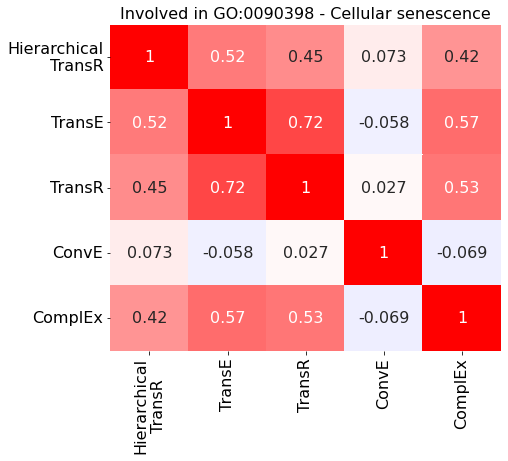

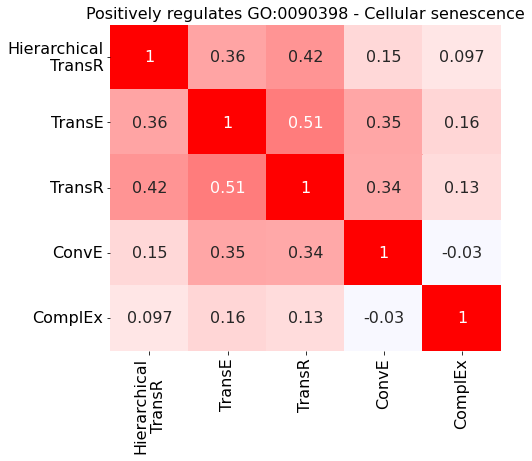

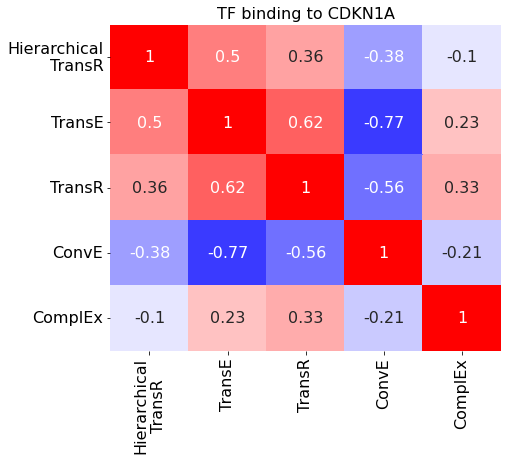

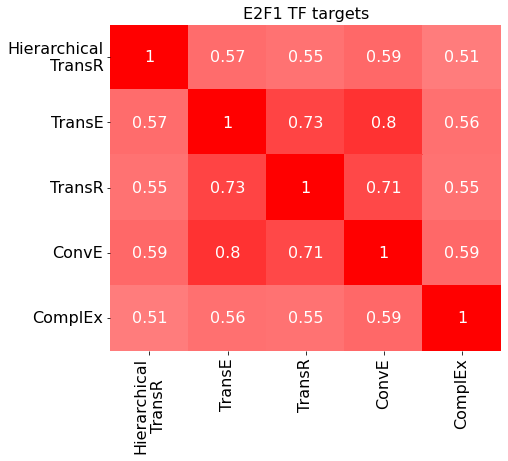

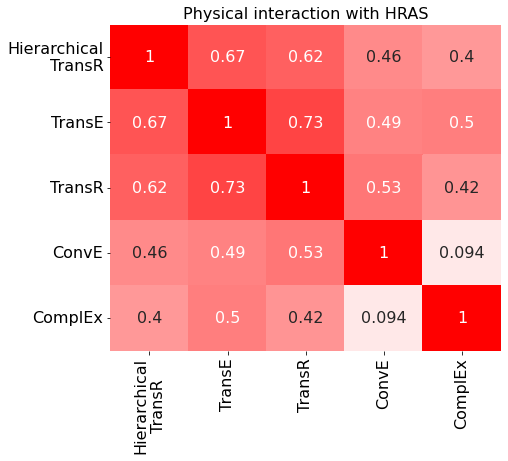

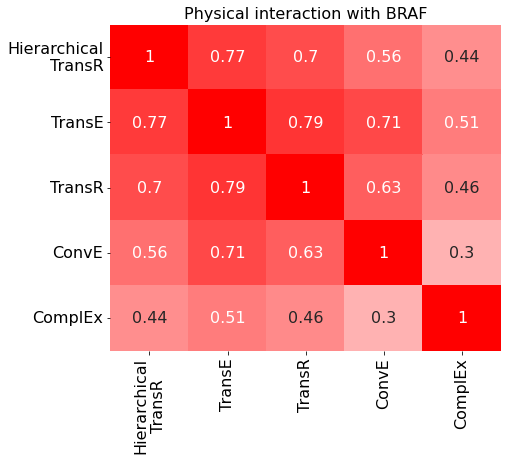

In [10]:
# plot correlations between scores

import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.size'] = 16

titles = ['Involved in GO:0090398 - Cellular senescence',
          'Positively regulates GO:0090398 - Cellular senescence',
          'TF binding to CDKN1A',
          'E2F1 TF targets',
          'Physical interaction with HRAS', 
          'Physical interaction with BRAF']

for preds, title, suffix in zip(all_preds, titles, ['a', 'b', 'c', 'd', 'e', 'f']):
    scores = preds.iloc[:,1:].dropna()
    scores.rename({'Hierarchical TransR': 'Hierarchical\nTransR'}, axis = 1, inplace = True)
    score_correlations = scores.corr(method = 'spearman')
    fig, ax = plt.subplots(figsize = (7, 6))
    sns.heatmap(score_correlations, cmap = 'bwr', cbar = False, 
                vmin = -1, vmax = 1, ax = ax, annot = True)
    ax.set_title(title, fontsize = 16)
    ax.set_xticklabels(scores.columns, rotation = 90, ha = 'center')
    ax.set_yticklabels(scores.columns, va = 'center')
    plt.savefig('../figures/fig6{}.png'.format(suffix), facecolor = 'white', dpi = 300, bbox_inches = 'tight')

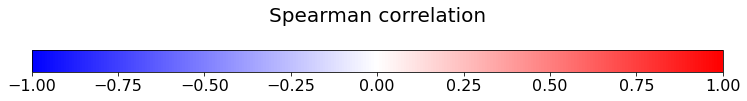

In [11]:
## plot colorbar used for all plots

scale = np.array([[-1, 1]])
plt.figure(figsize = (12, 0.5))
img = plt.imshow(scale, cmap = 'bwr')
plt.gca().set_visible(False)
cax = plt.axes([0.1, 0.2, 0.8, 0.6])
plt.colorbar(orientation = 'horizontal', cax=cax)
plt.title('Spearman correlation\n', fontsize = 20)
plt.savefig('../figures/fig6_colorbar.png', dpi = 300, facecolor = 'white', bbox_inches = 'tight')

In [12]:
# print top predictions for all 6 facts

query_entities = ['GO:0090398 - Cellular senescence', 
                  'GO:0090398 - Cellular senescence',
                  'CDKN1A',
                  'E2F1', 
                  'HRAS', 
                  'BRAF']

for preds, pred_type in zip(all_preds, titles):
    print(pred_type)
    for column in preds.iloc[:,1:].columns:
        pred_entity = preds.iloc[:,0][preds[column].argmax()]
        pred_entity_type = model.node_entries[model.node_lab2id[pred_entity]]['labels']
        if pred_entity_type == ['Gene']:
            symbol = model.node_entries[model.node_lab2id[pred_entity]]['properties']['symbol']
            pred_entity_name = symbol if symbol != 'NA' else pred_entity
        else:
            pred_entity_desc = model.node_entries[model.node_lab2id[pred_entity]]['properties']['description']
            pred_entity = pred_entity.replace('_', ':')
            pred_entity_name = pred_entity + ' - ' + pred_entity_desc
        print(column + ' - ' + pred_entity_name)
    print('\n')

Involved in GO:0090398 - Cellular senescence
Hierarchical TransR - SUV39H1
TransE - SIRT1
TransR - MSX1
ConvE - AMY2B
ComplEx - SPRY2


Positively regulates GO:0090398 - Cellular senescence
Hierarchical TransR - GO:0010424 - DNA methylation on cytosine within a CG sequence
TransE - GO:2000773 - negative regulation of cellular senescence
TransR - GO:0010831 - positive regulation of myotube differentiation
ConvE - GO:1903891 - regulation of ATF6-mediated unfolded protein response
ComplEx - GO:0090331 - negative regulation of platelet aggregation


TF binding to CDKN1A
Hierarchical TransR - HBP1
TransE - E2F1
TransR - KAT2B
ConvE - IGDCC4
ComplEx - KAT2A


E2F1 TF targets
Hierarchical TransR - DUSP5
TransE - ZNF697
TransR - NTNG1
ConvE - ENSG00000287724
ComplEx - AGO4


Physical interaction with HRAS
Hierarchical TransR - NRAS
TransE - NRAS
TransR - NRAS
ConvE - TFAP2C
ComplEx - SLC7A2


Physical interaction with BRAF
Hierarchical TransR - CAV1
TransE - RAF1
TransR - MAPK8
ConvE - HNRNPL


In [20]:
# predict pathway facts using hierarchical TransR

atr_reg_gene_preds = get_predictions_hTr(model, 
                                         general_relation_lab = 'CONTROLS_STATE_CHANGE_OF', 
                                         specific_relation_lab = 'Activation of ATR in response to replication stress', 
                                         entity_lab = 'ENSG00000175054', 
                                         which = 'head', 
                                         entity_type = 'Gene')

tp53_target_gene_preds = get_predictions_hTr(model, 
                                          general_relation_lab = 'CONTROLS_STATE_CHANGE_OF', 
                                          specific_relation_lab = 'DNA Damage/Telomere Stress Induced Senescence', 
                                          entity_lab = 'ENSG00000141510', 
                                          which = 'tail', 
                                          entity_type = 'Gene')

tp53_phosp_gene_preds = get_predictions_hTr(model, 
                                            general_relation_lab = 'CONTROLS_PHOSPHORYLATION_OF', 
                                            specific_relation_lab = 'TP53 Regulates Transcription of DNA Repair Genes', 
                                            entity_lab = 'ENSG00000141510', 
                                            which = 'head', 
                                            entity_type = 'Gene')

il6_expr_gene_preds = get_predictions_hTr(model, 
                                          general_relation_lab = 'CONTROLS_EXPRESSION_OF', 
                                          specific_relation_lab = 'Senescence-Associated Secretory Phenotype (SASP)', 
                                          entity_lab = 'ENSG00000136244', 
                                          which = 'head', 
                                          entity_type = 'Gene')

rela_reg_gene_preds = get_predictions_hTr(model, 
                                          general_relation_lab = 'CONTROLS_STATE_CHANGE_OF', 
                                          specific_relation_lab = 'Senescence-Associated Secretory Phenotype (SASP)', 
                                          entity_lab = 'ENSG00000173039', 
                                          which = 'head', 
                                          entity_type = 'Gene')

cdkn2a_expr_gene_preds = get_predictions_hTr(model, 
                                             general_relation_lab = 'CONTROLS_EXPRESSION_OF', 
                                             specific_relation_lab = 'Oxidative Stress Induced Senescence', 
                                             entity_lab = 'ENSG00000147889', 
                                             which = 'head', 
                                             entity_type = 'Gene')

hierarchical_TransR_preds = [atr_reg_gene_preds, 
                             tp53_target_gene_preds, 
                             tp53_phosp_gene_preds, 
                             il6_expr_gene_preds, 
                             rela_reg_gene_preds, 
                             cdkn2a_expr_gene_preds]

In [22]:
# print hierarchical TransR predictions 

hierarchical_TransR_relationships = ['Controls state change of ATR (Activation of ATR in response to replication stress)',
                                     'Targeted by TP53 (DNA Damage/Telomere Stress Induced Senescence)',
                                     'Phosphorylates TP53 (TP53 Regulates Transcription of DNA Repair Genes)',
                                     'Controls expression of IL6 (SASP)',
                                     'Controls state change of RELA (SASP)',
                                     'Controls expression of CDKN2A (Oxidative Stress Induced Senescence)']

for rel, preds in zip(hierarchical_TransR_relationships, hierarchical_TransR_preds):
    top_pred = preds.iloc[0, 0]
    symbol = model.node_entries[model.node_lab2id[top_pred]]['properties']['symbol']
    print(rel + ' - ' + symbol)

Controls state change of ATR (Activation of ATR in response to replication stress) - BRIP1
Targeted by TP53 (DNA Damage/Telomere Stress Induced Senescence) - SUMO1
Phosphorylates TP53 (TP53 Regulates Transcription of DNA Repair Genes) - CDC25A
Controls expression of IL6 (SASP) - NGF
Controls state change of RELA (SASP) - NFKBIB
Controls expression of CDKN2A (Oxidative Stress Induced Senescence) - RUNX1
